# Montecarlo simulation for estimating the geodesic attitude error given the errors on the measurements

Author: Anthony Kalaydjian

In [1]:
import numpy as np
from math import *
import matplotlib.pyplot as plt
import scipy

In [2]:
mean_1   = 0.67*pi/180
mean_2   = 0.87*pi/180
std_1    = 0.43*pi/180
std_2    = 0.62*pi/180

In [3]:
N_iter = 100000

In [4]:
def q_from_angle_axis(angle, axis):
    axis = np.array(axis).squeeze()
    q = np.concatenate([sin(angle/2)*axis, cos(angle/2)*np.array([1])])

    q = np.matrix(q).transpose()
    return q

In [5]:
def q_to_R(q):
    """
    Returns the rotation matrix associated to the rotation defined by the quaternion
    """
    q = q.squeeze()
    try:
        q1 = q[0]
        q2 = q[1]
        q3 = q[2]
        q4 = q[3]
    except:
        q1 = q[0,0]
        q2 = q[0,1]
        q3 = q[0,2]
        q4 = q[0,3]

    R = np.matrix(
        [
            [1 - 2*(q2**2 + q3**2), 2*(q1*q2 - q3*q4), 2*(q1*q3 + q4*q2), 0],
            [2*(q1*q2 + q4*q3), 1 - 2*(q1**2 + q3**2), 2*(q2*q3 - q1*q4), 0],
            [2*(q1*q3 - q4*q2), 2*(q2*q3 + q4*q1), 1 - 2*(q1**2 + q2**2), 0],
            [0, 0, 0, 1]
        ]
    )

    return R.squeeze()

In [6]:
def triad_error(v1_I, v2_I, v1_BODY_measurement, v2_BODY_measurement, P_I_BODY):
    t1 = v1_I
    t1 = t1/np.linalg.norm(t1)
    t3 = np.cross(t1, v2_I, axis=0)
    t3 = t3/np.linalg.norm(t3)
    t2 = np.cross(t3, t1, axis=0)

    t1_BODY_measurement = v1_BODY_measurement
    t1_BODY_measurement = t1_BODY_measurement/np.linalg.norm(t1_BODY_measurement)
    t3_BODY_measurement = np.cross(t1_BODY_measurement, v2_BODY_measurement, axis=0)
    t3_BODY_measurement = t3_BODY_measurement/np.linalg.norm(t3_BODY_measurement)
    t2_BODY_measurement = np.cross(t3_BODY_measurement, t1_BODY_measurement, axis=0)

    P_I_TRIAD = np.concatenate([t1, t2, t3], axis=1)
    P_BODY_TRIAD_measurement = np.concatenate([t1_BODY_measurement, t2_BODY_measurement, t3_BODY_measurement], axis=1)
    P_I_BODY_triad_measurement = P_I_TRIAD@P_BODY_TRIAD_measurement.transpose()

    error_matrix = P_I_BODY_triad_measurement@P_I_BODY.transpose()

    angle = (np.trace(error_matrix) - 1)/2

    #fixing epsilon machine errors
    if (np.abs(angle - 1)>0 and np.abs(angle - 1)<1e-15):
        error_angle=0
    elif (np.abs(angle + 1)>0 and np.abs(angle + 1)<1e-15):
        error_angle=pi
    else:
        error_angle = np.arccos((np.trace(error_matrix) - 1)/2)

    return error_angle

In [7]:
np.random.seed(12)
error_list = []

for i in range(N_iter):
    v1_I = np.random.random(3)
    v2_I = np.random.random(3)

    v1_I = v1_I/np.linalg.norm(v1_I)
    v2_I = v2_I/np.linalg.norm(v2_I)

    v1_I = np.matrix(v1_I).transpose()
    v2_I = np.matrix(v2_I).transpose()

    attitude_q = np.random.random(4)
    attitude_q = attitude_q/np.linalg.norm(attitude_q)
    P_I_BODY = q_to_R(attitude_q)[0:3, 0:3]

    v1_BODY = P_I_BODY.transpose()@v1_I
    v2_BODY = P_I_BODY.transpose()@v2_I


    angle_error_1 = np.abs(np.random.normal(loc=mean_1, scale=std_1))
    angle_error_2 = np.abs(np.random.normal(loc=mean_2, scale=std_2))

    axis_1 = np.random.random(3)
    axis_2 = np.random.random(3)

    axis_1 = axis_1/np.linalg.norm(axis_1)
    axis_2 = axis_2/np.linalg.norm(axis_2)

    q1 = q_from_angle_axis(angle_error_1, axis_1)
    q2 = q_from_angle_axis(angle_error_2, axis_2)

    R1 = q_to_R(q1)[0:3, 0:3]
    R2 = q_to_R(q2)[0:3, 0:3]

    v1_BODY_measurement = R1@v1_BODY
    v2_BODY_measurement = R2@v2_BODY

    error = triad_error(v1_I, v2_I, v1_BODY_measurement, v2_BODY_measurement, P_I_BODY)
    error_list.append(error)

error_list = np.array(error_list)*180/pi
print(f"MEAN    :{np.mean(error_list)}")
print(f"STD     :{np.std(error_list)}")

MEAN    :1.2926423323746492
STD     :2.2433637046312294


Text(0, 0.5, 'frequency')

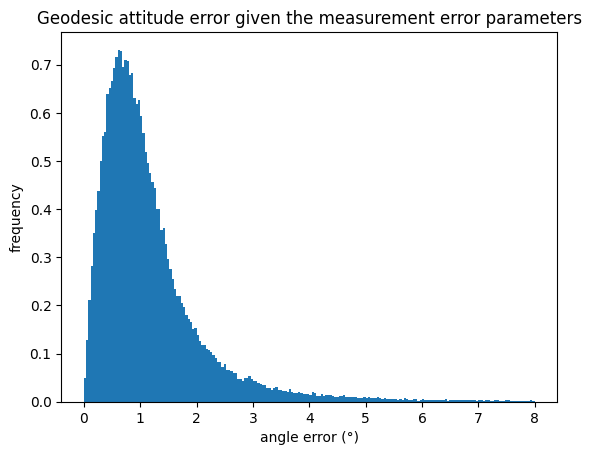

In [8]:
plt.hist(error_list, bins=200, density=True, range=[0, 8])
plt.title("Geodesic attitude error given the measurement error parameters")
plt.xlabel("angle error (°)")
plt.ylabel("frequency")